In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

seed = 42
path = '/content/drive/My Drive/Colab Notebooks/'

np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
df = pd.read_csv(path + 'london_merged.csv', parse_dates=['timestamp'], index_col='timestamp')
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


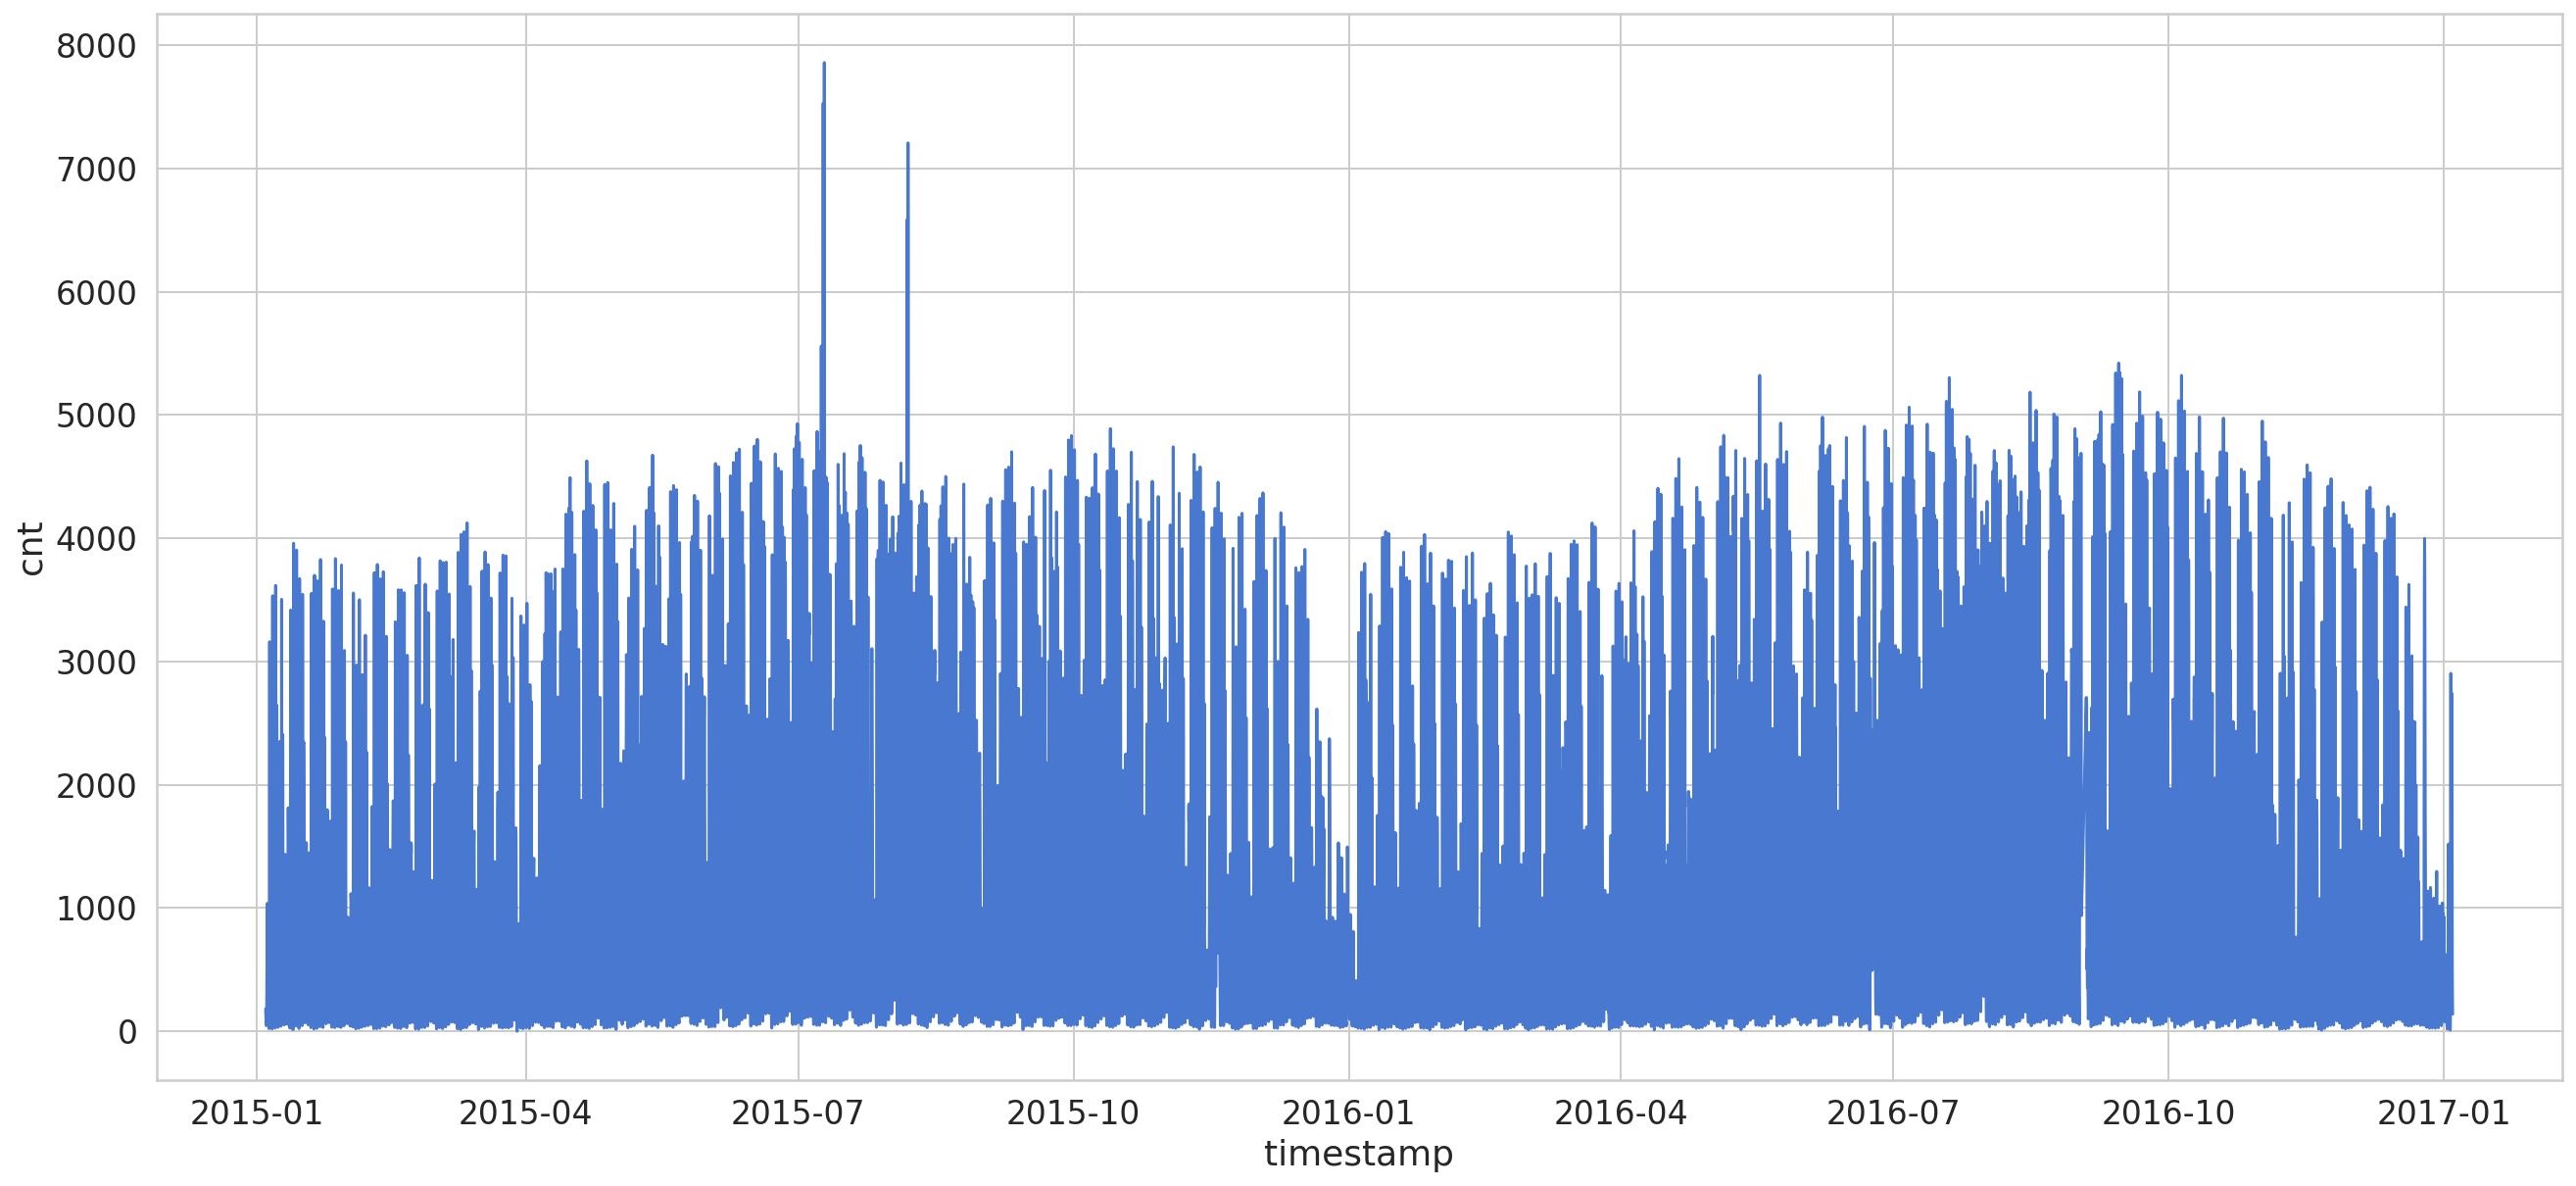

In [ ]:
sns.lineplot(x=df.index, y='cnt', data=df)

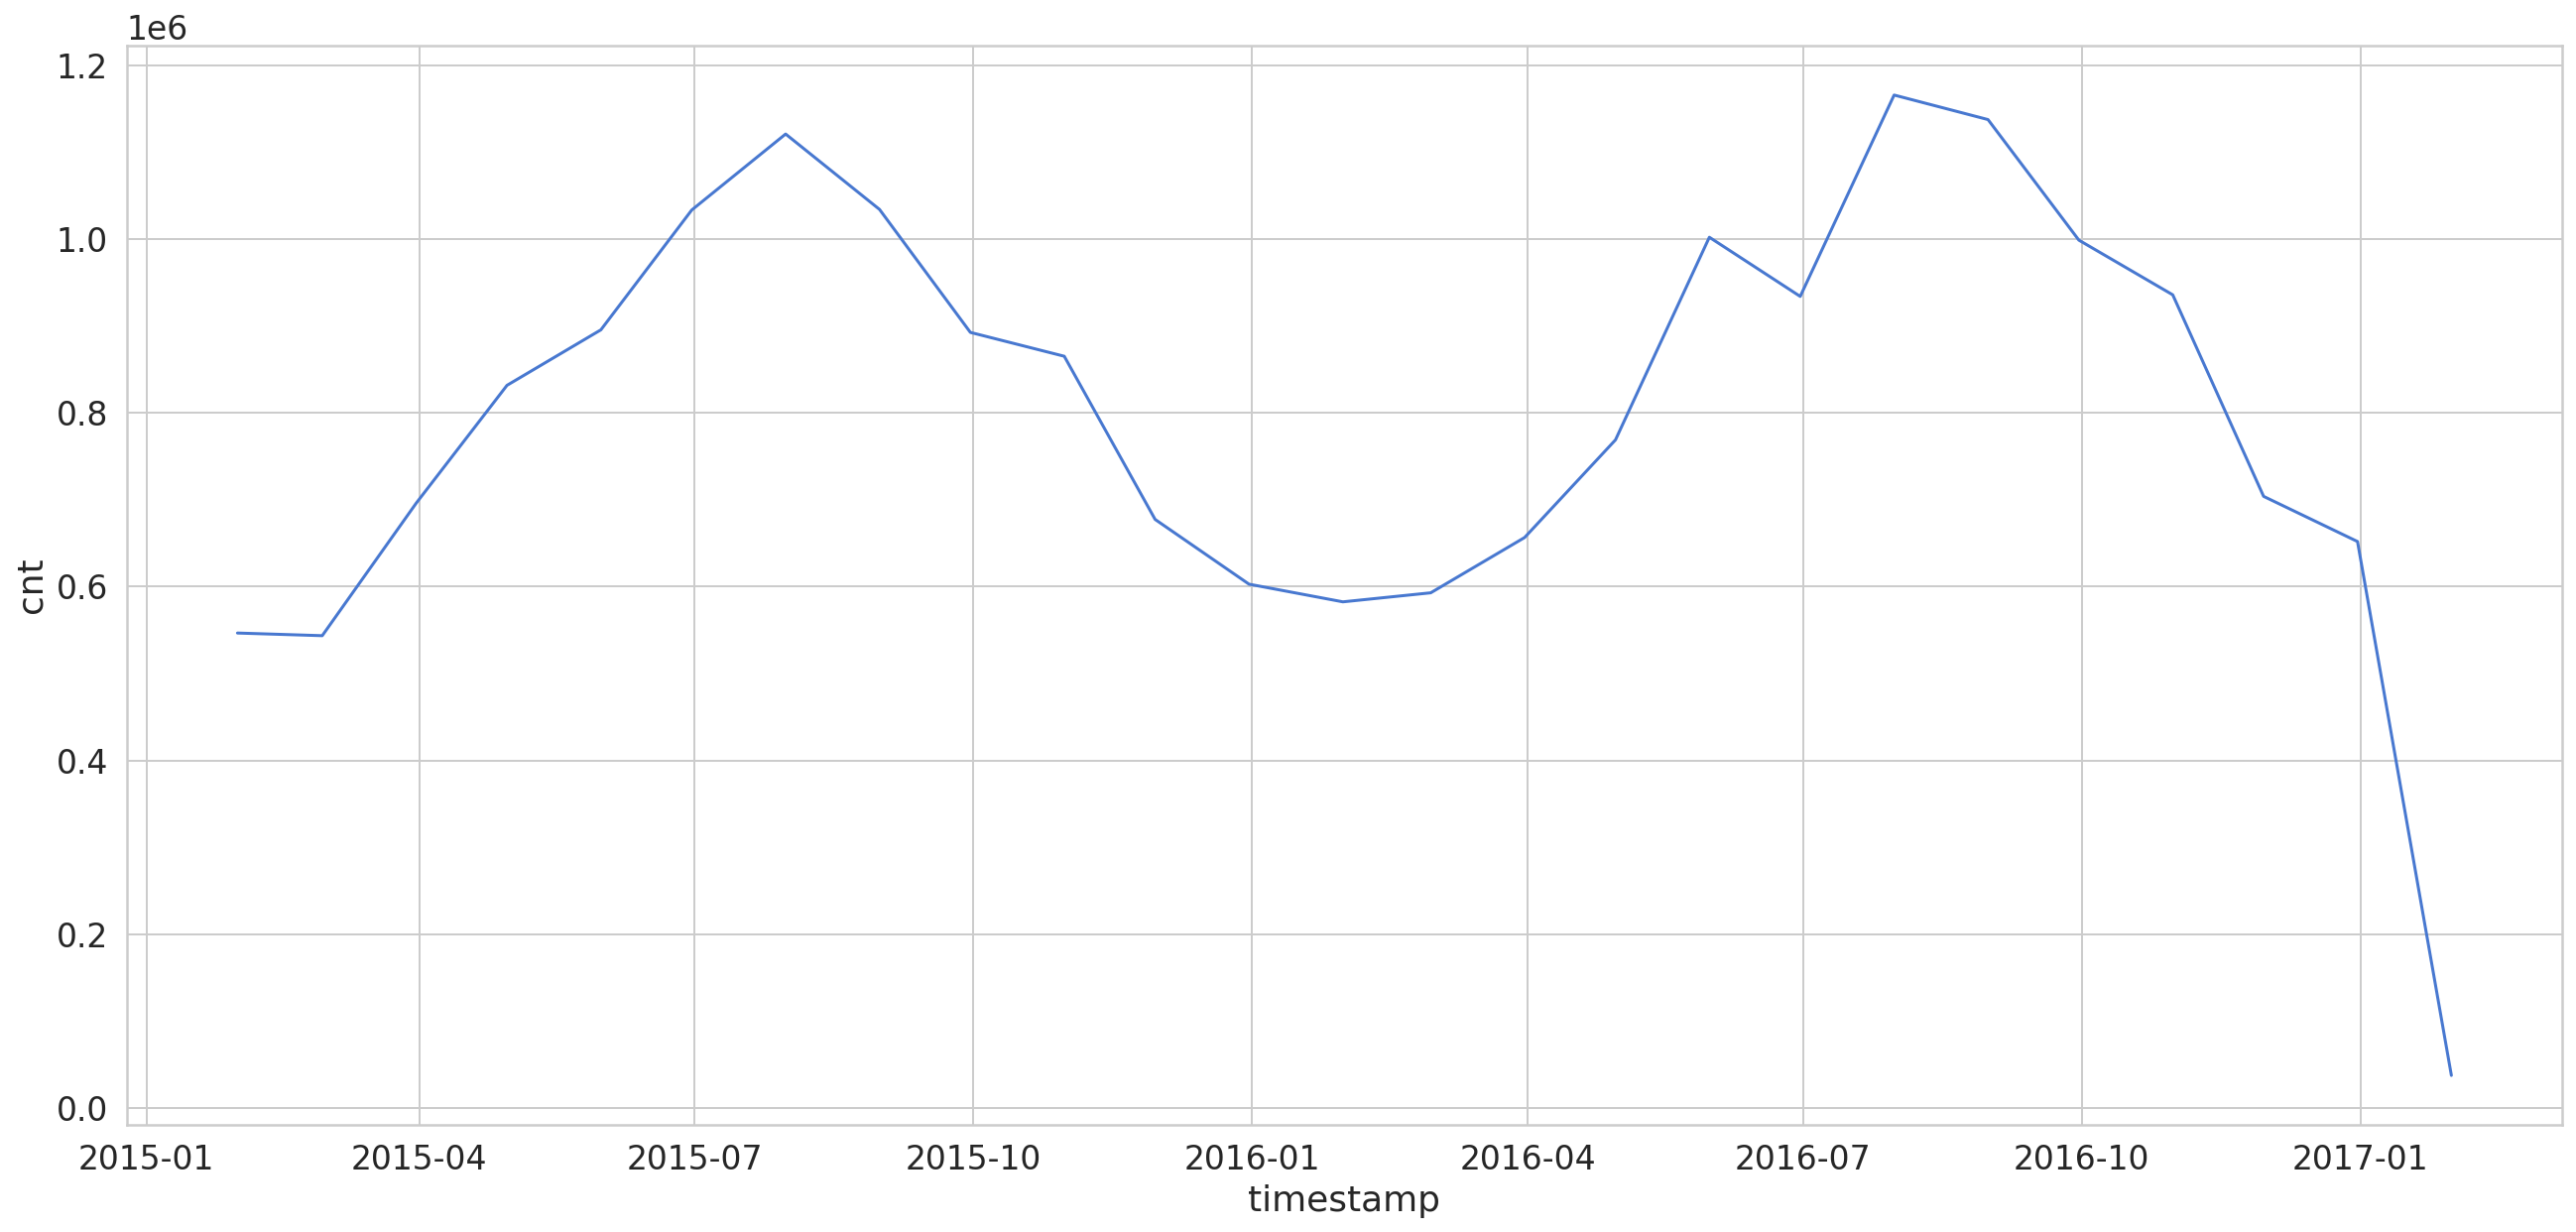

In [ ]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month)

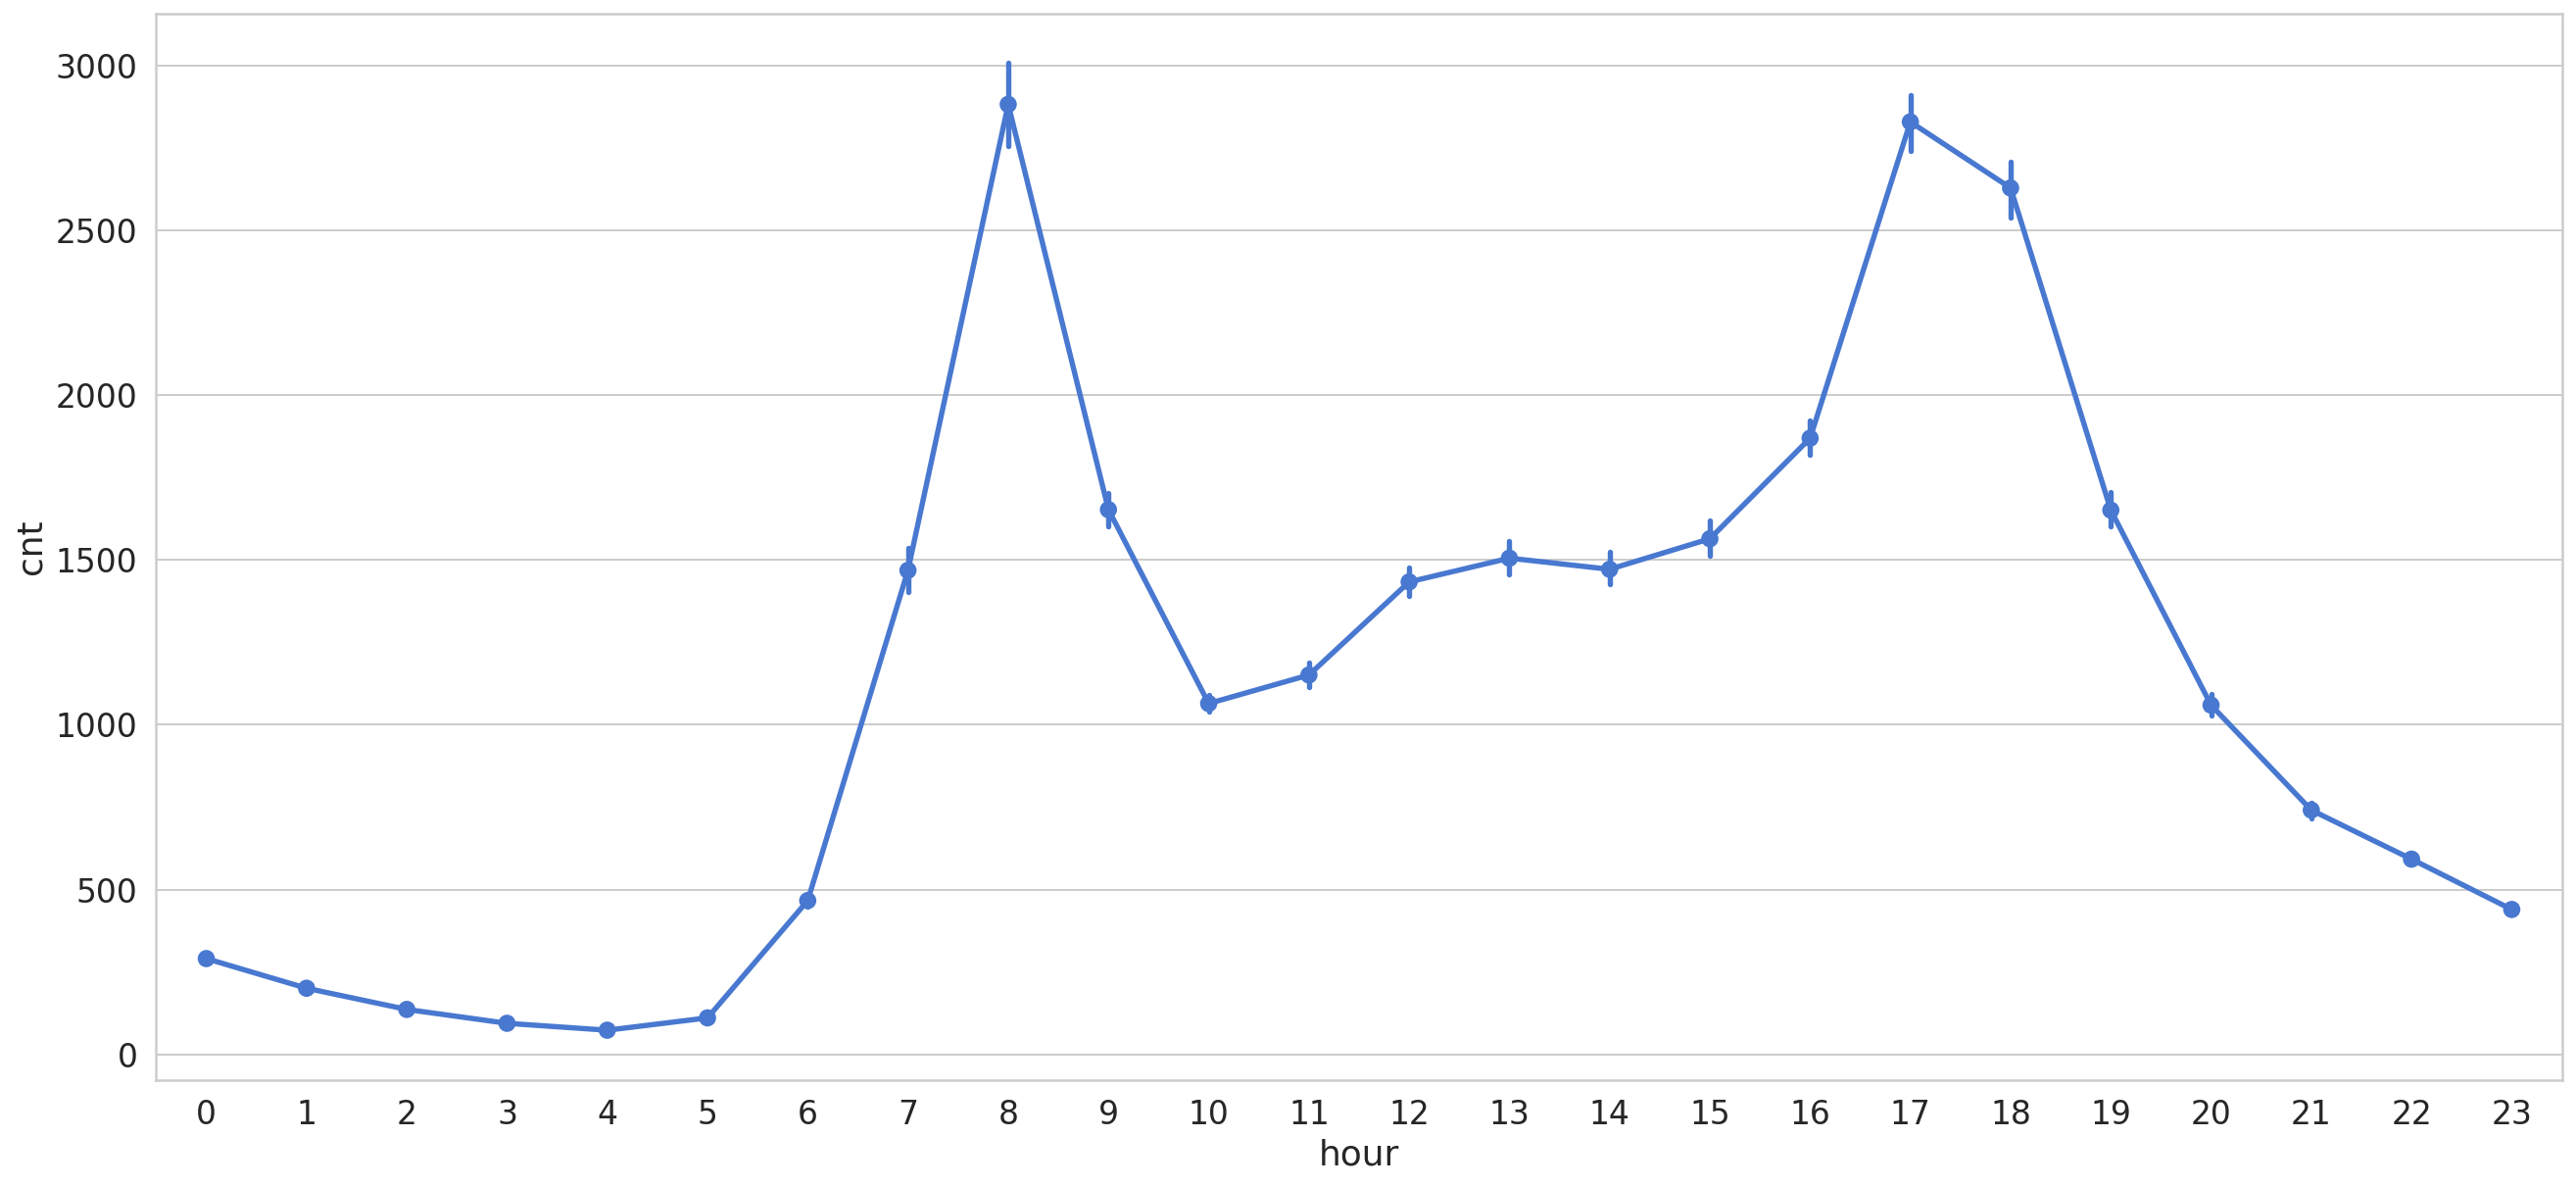

In [ ]:
sns.pointplot(data=df, x='hour', y='cnt')

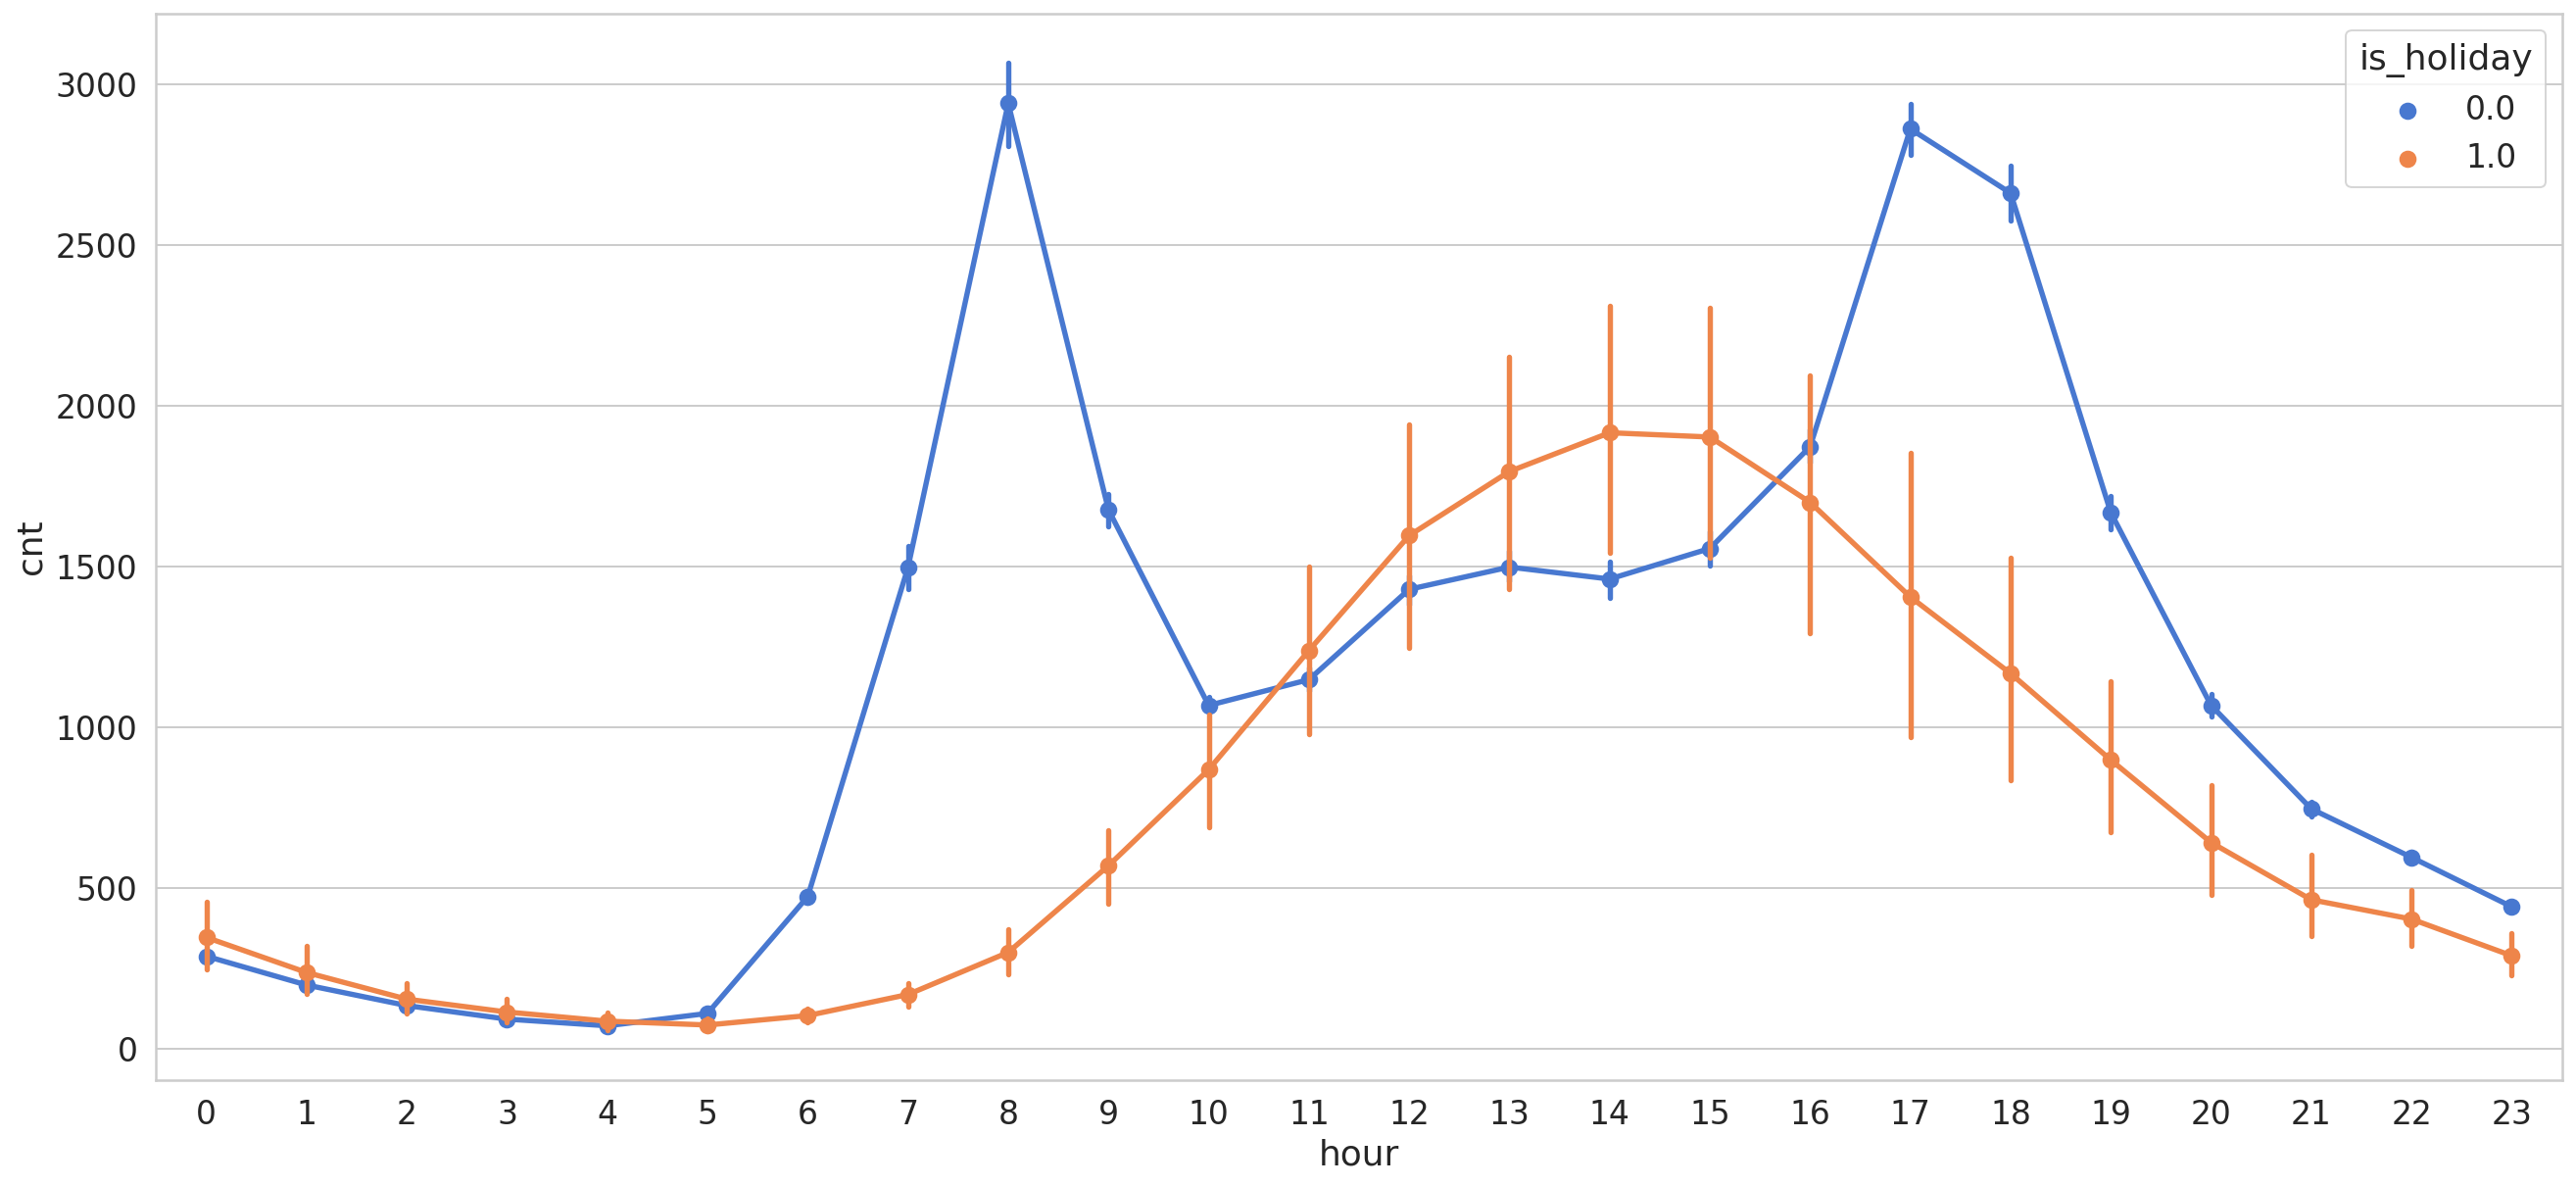

In [ ]:
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday')

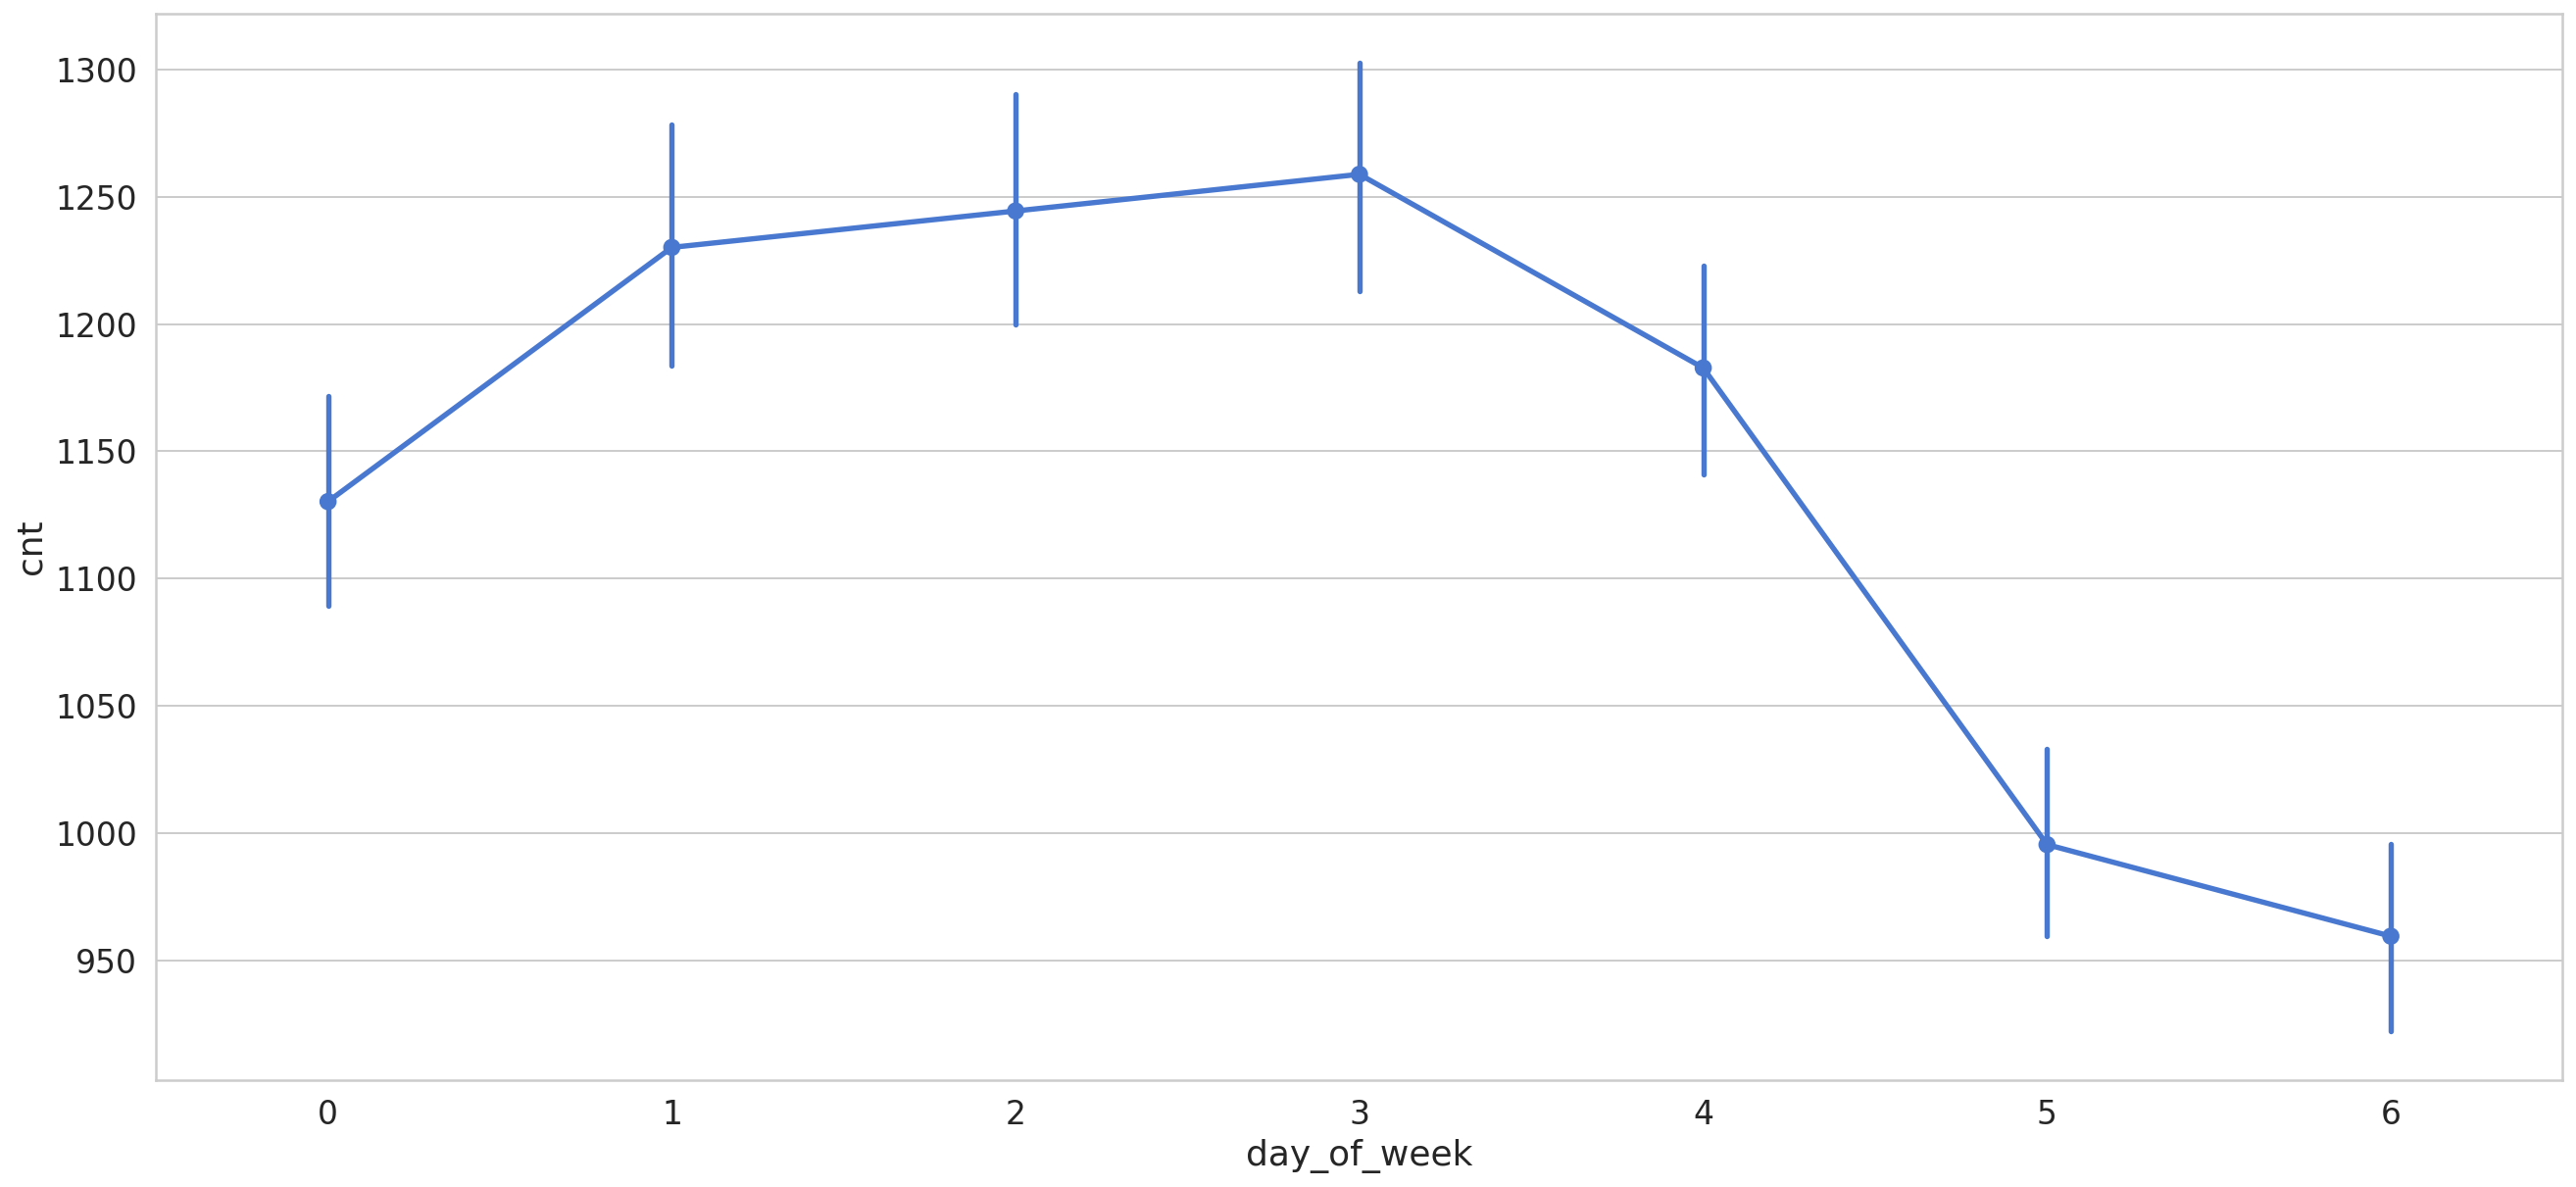

In [ ]:
sns.pointplot(data=df, x='day_of_week', y='cnt')

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(15672, 13) (1742, 13)


## Preprocessing

In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])


test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [ ]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 24

X_train, y_train = create_dataset(train, train.cnt, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.cnt, time_steps=TIME_STEPS)

In [ ]:
# [samples. time_steps, n_features]
print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


In [ ]:
print(X_test.shape, y_test.shape)

(1718, 24, 13) (1718,)


In [ ]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 25s 46ms/step - loss: 0.3233 - val_loss: 0.1592
Epoch 2/30
441/441 [==============================] - 19s 42ms/step - loss: 0.1123 - val_loss: 0.0682
Epoch 3/30
441/441 [==============================] - 19s 44ms/step - loss: 0.0658 - val_loss: 0.0489
Epoch 4/30
441/441 [==============================] - 20s 44ms/step - loss: 0.0456 - val_loss: 0.0423
Epoch 5/30
441/441 [==============================] - 20s 45ms/step - loss: 0.0388 - val_loss: 0.0340
Epoch 6/30
441/441 [==============================] - 19s 43ms/step - loss: 0.0332 - val_loss: 0.0385
Epoch 7/30
441/441 [==============================] - 19s 44ms/step - loss: 0.0291 - val_loss: 0.0432
Epoch 8/30
441/441 [==============================] - 19s 43ms/step - loss: 0.0283 - val_loss: 0.0310
Epoch 9/30
441/441 [==============================] - 19s 44ms/step - loss: 0.0256 - val_loss: 0.0419
Epoch 10/30
441/441 [==============================] - 19s 43ms/step - loss: 0.024

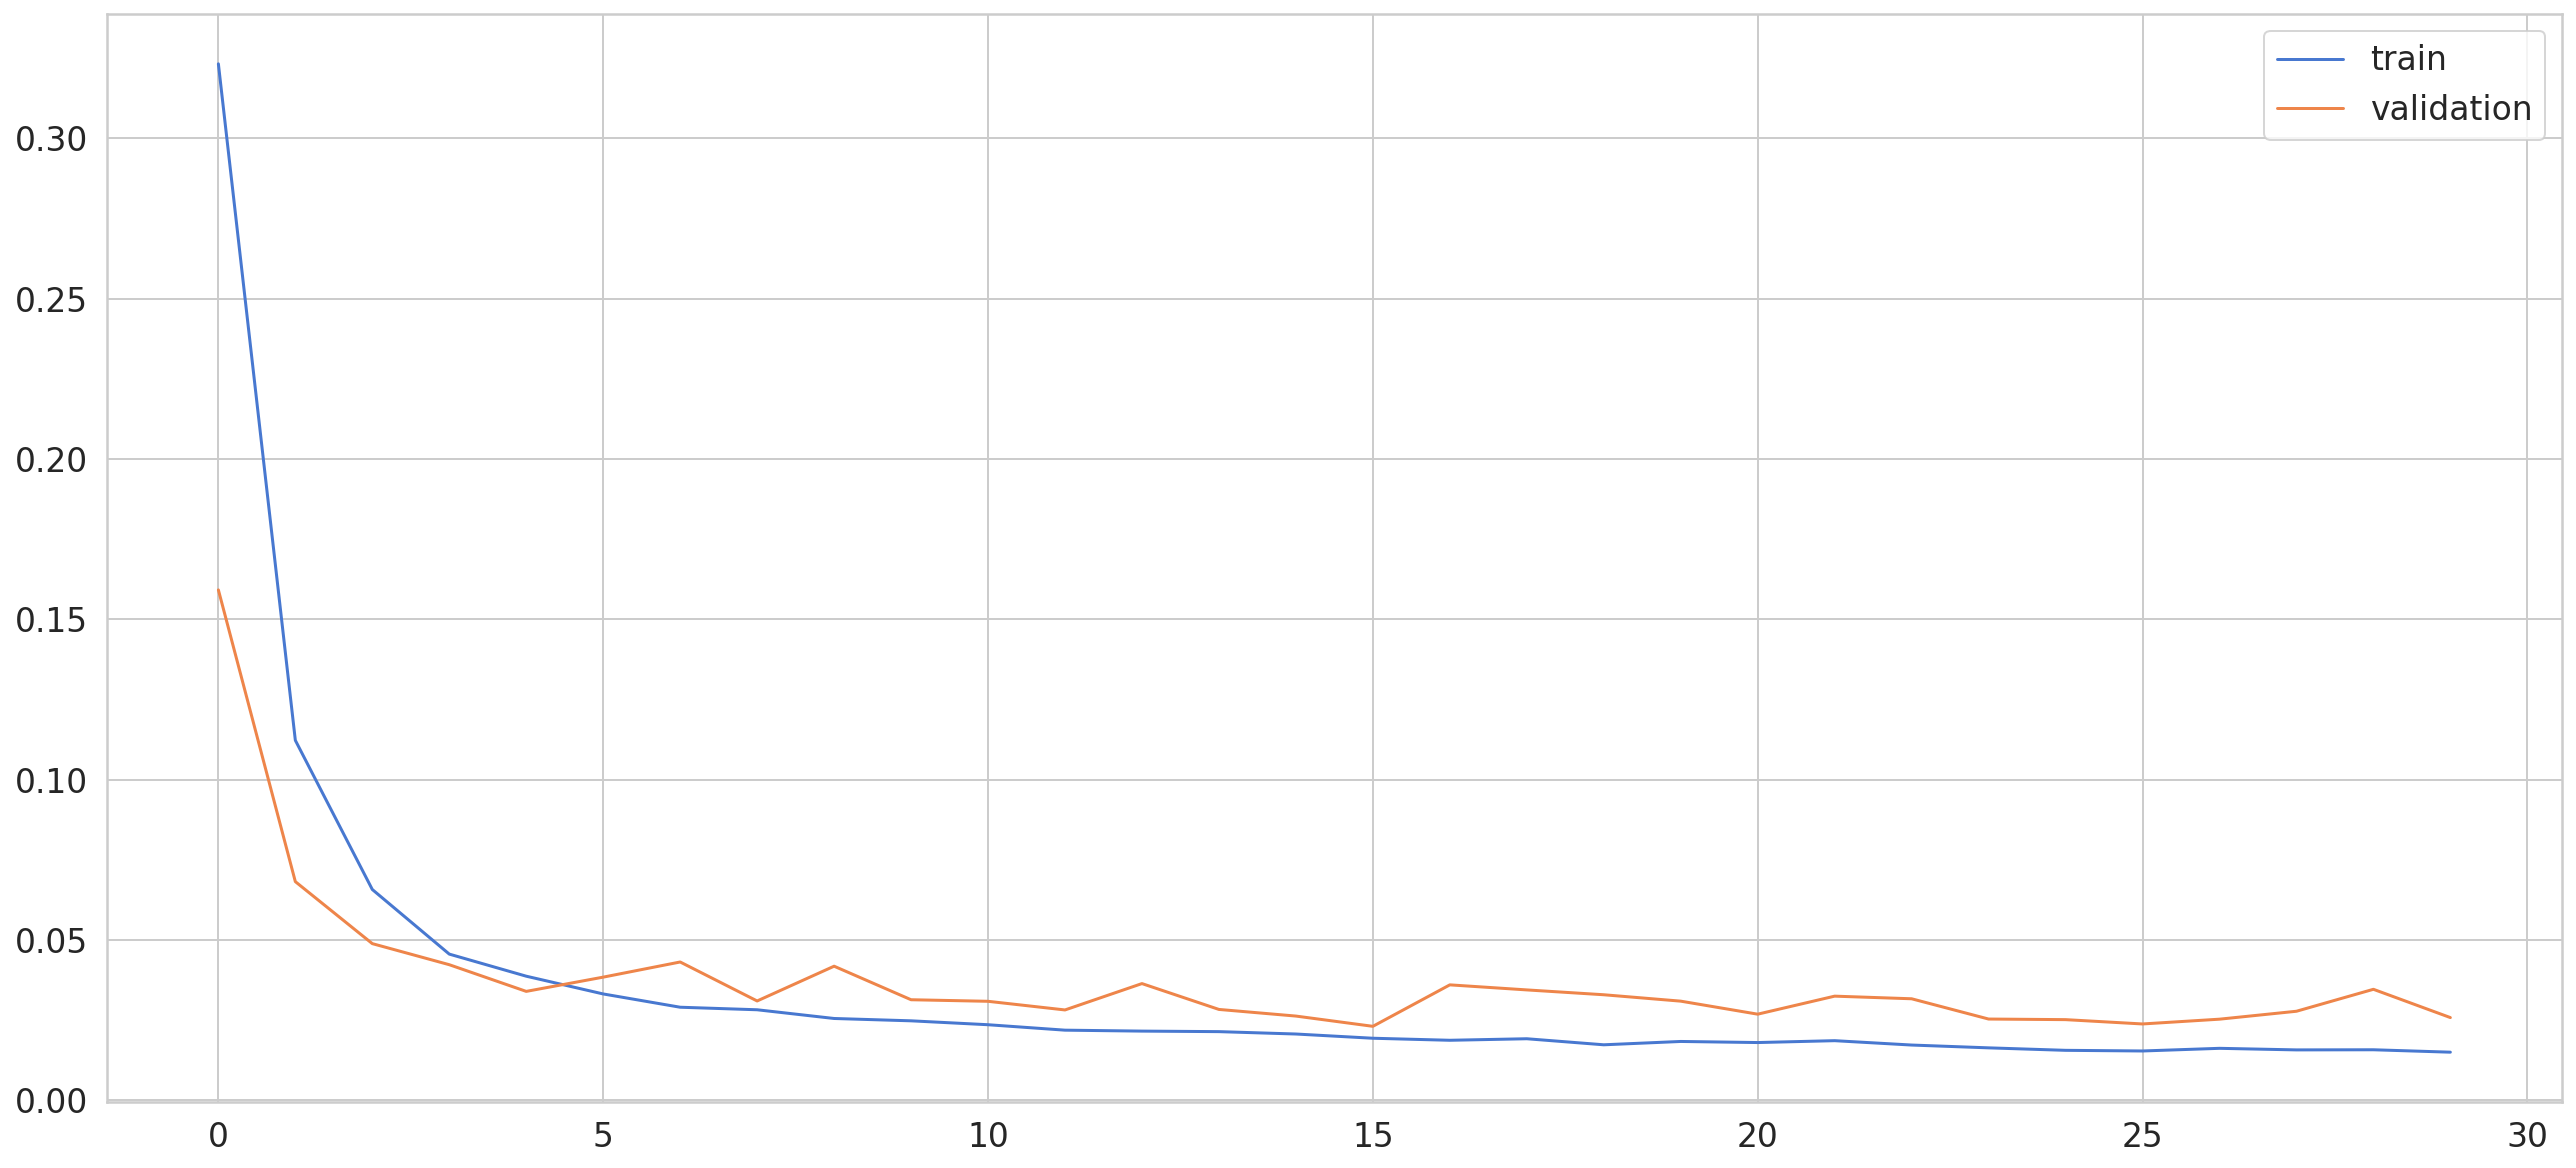

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

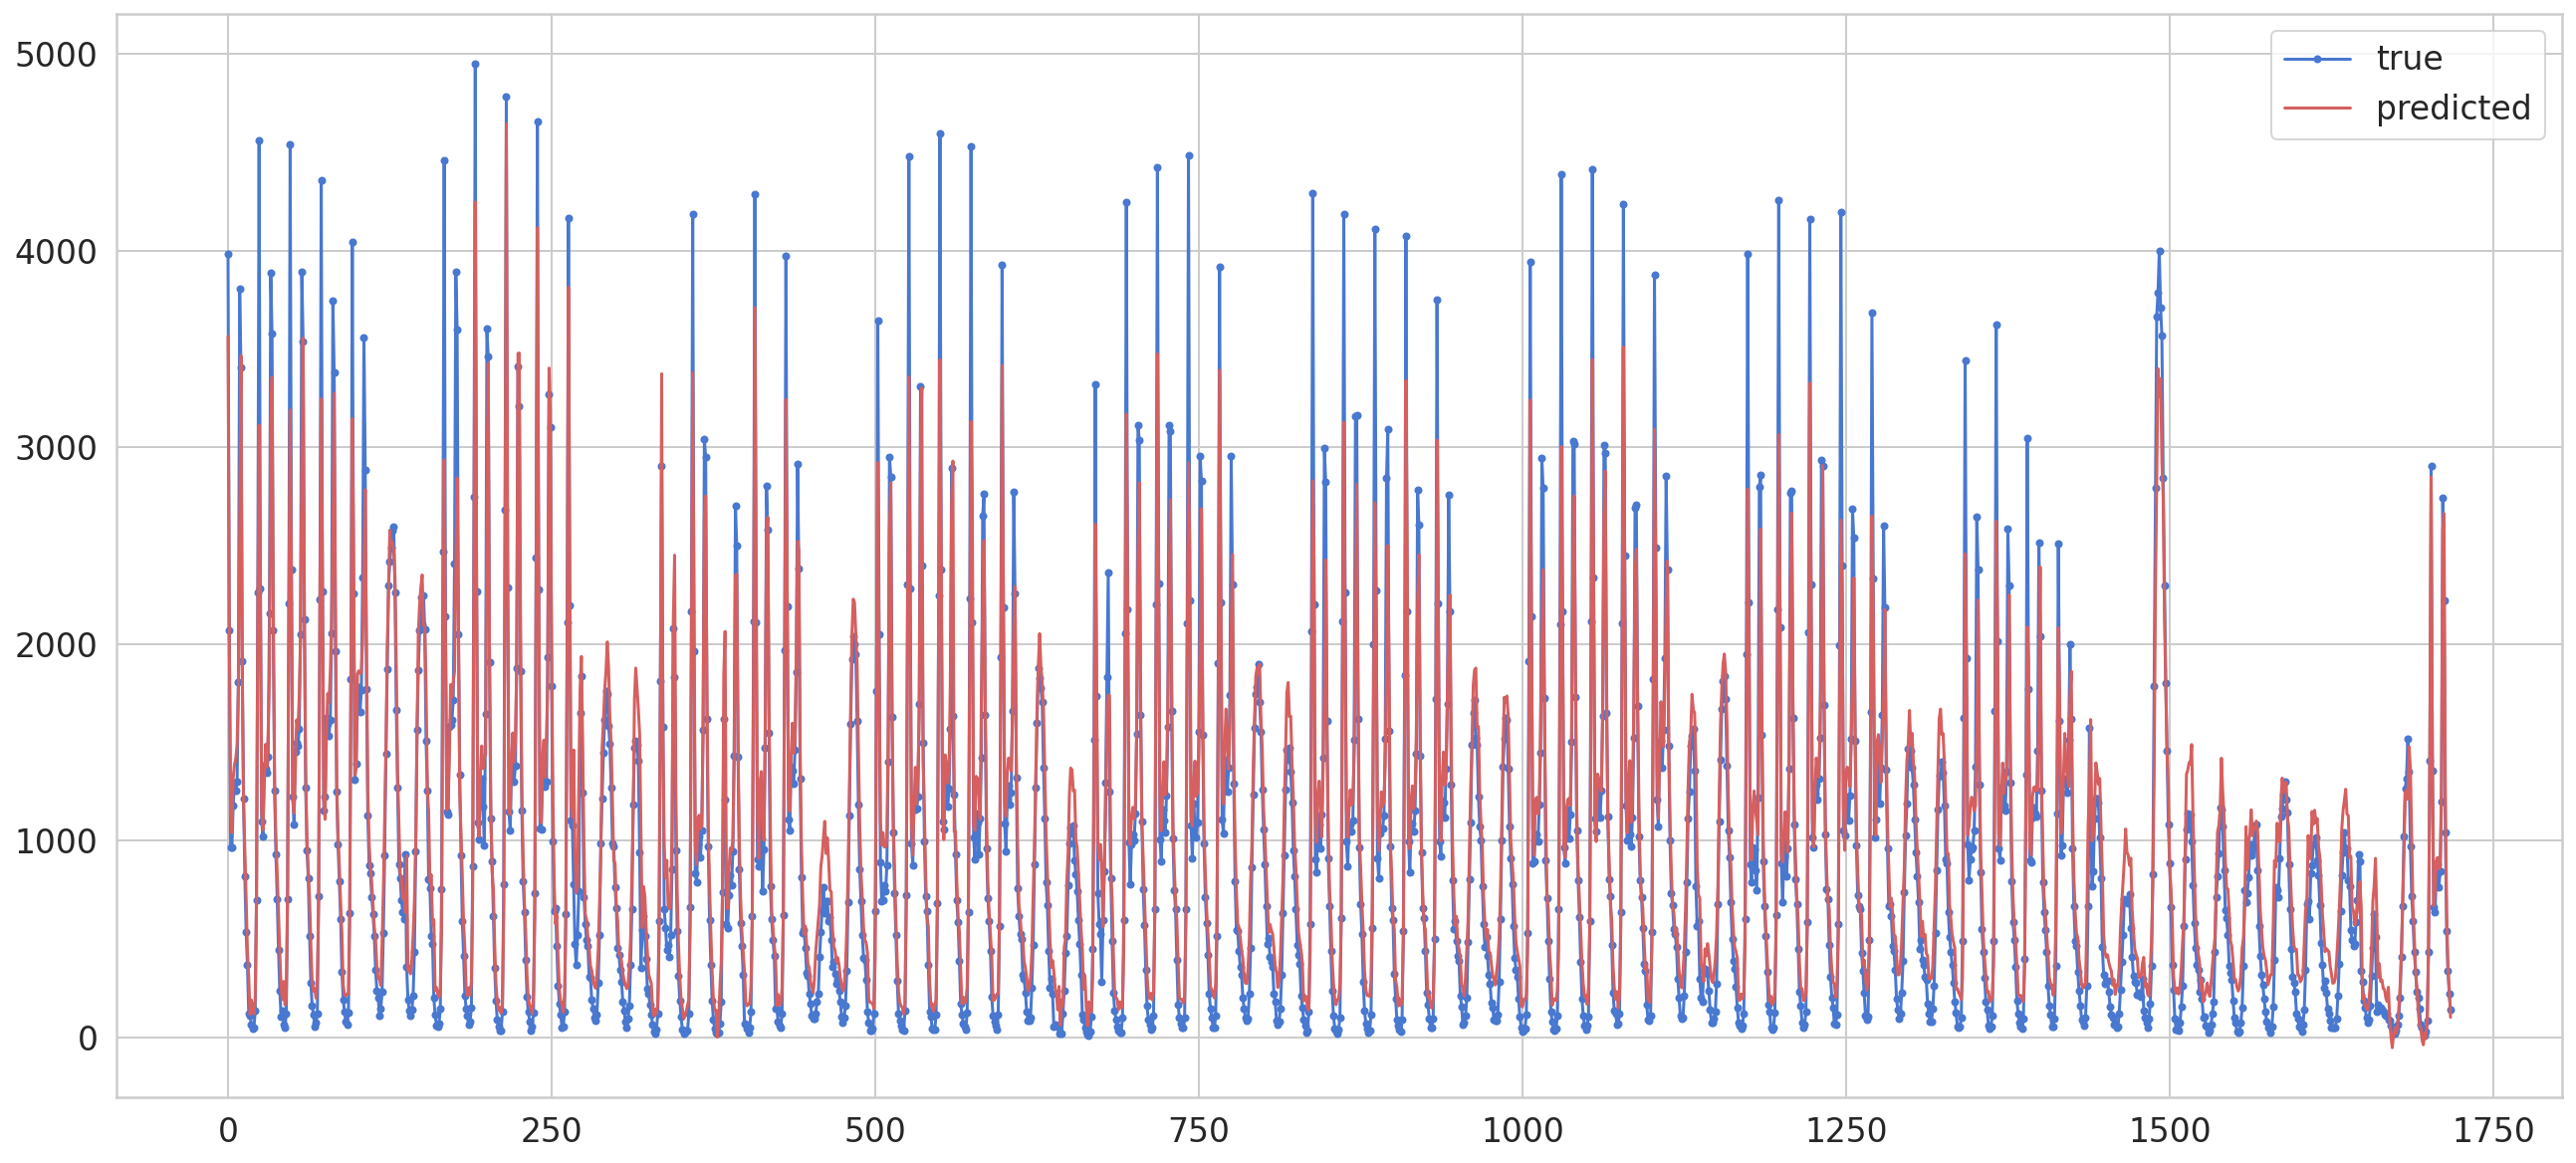

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend()